In [1]:
import pandas as pd
import numpy as np
from tsa.preprocessing import get_sample_info, tpm_normalization
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.tsa import best_alignment_graph
from tsa.utils import list2floats, inference_timeseries
from tsa.plotting import plot_alignments
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from qnorm import quantile_normalize
import warnings
import sklearn
import random
from sklearn.cluster import k_means, KMeans
from sklearn.decomposition import PCA

### Pinned variables
- normalization: 5 TPM minimum, quantile normalization & log transformation
- template GPR with 10 points/timepoint
- distance metric: euclidean (where possible)

In [2]:
tpm_file = "data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "data/white_mpf_samples.tsv"
query_samples_file = "data/levin_mpf_samples.tsv"

In [3]:
# target_distribution = template_tpms[template_tpms.columns[0]].to_list()
# query_tpms = quantile_normalize(query_tpms, axis=1, target=target_distribution)

def tpm_normalization(
        tpms: pd.DataFrame,
        column_order: list,
#         genes: list = None
        minimum_value: int = None,
        target: list = None,
) -> pd.DataFrame:
    # filter samples
    bc = tpms[column_order]                             # filter & order samples
    
    # filter genes
    if minimum_value:
        b4 = bc.shape[0]
        bc = bc[bc.max(axis=1) >= minimum_value]        # filter genes by minimum
        aft = b4 - bc.shape[0]
        print(f"Genes with TPM below {minimum_value}: {aft} of {b4} ({round(100*aft/b4,0)}%)")
    bc = bc[bc.median(axis=1) > 0]                      # filter genes by median
    
    # normalize & transform
    if target:
        if len(bc) < len(target):
            # subsample distribution to number of genes
            target = random.sample(target, len(bc))
        elif len(bc) > len(target):
            raise NotImplementedError("query has more genes than target distribution...")
    bc = quantile_normalize(bc, axis=1, target=target)  # normalize
    bc = np.log2(bc+1)                                  # transform
    return bc

In [4]:
def get_cost_matrix(template_tpms, query_tpms, metric='euclidean'):
    template = template_tpms.to_numpy(dtype=np.float64)
    query = query_tpms.to_numpy(dtype=np.float64)
    cost_matrix = cdist(template.T, query.T, metric=metric).T  # pairwise distance matrix
    return cost_matrix

def subset_df(df, rows=None, columns=None, sort=True):
    """
    (efficiently) reconstruct a dataframe by row and/or column (name or number)
    
    rows: list of row/index names or numbers
    columns: list of column names or numbers
    """
    if rows:
        if set(rows).issubset(set(df.index)):
            # rows contains dataframe row names
            df = df[df.index.isin(rows)]
        else:
            # rows contains dataframe row numbers
            df = df.iloc[rows]
    if columns:
        if set(columns).issubset(set(df.columns)):
            # columns contains dataframe column names
            df = df[columns]
        else:
            # columns contains dataframe column numbers
            df = df[[df.columns[i] for i in columns]]
    if sort:
        df.sort_index(inplace=True)
    return df

def plot_alignment(cost_matrix, best_path, std_path=None):
    q = cost_matrix.index.to_list()
    extended_template_time = list2floats(cost_matrix.columns)
    t = [extended_template_time[i] for i in best_path]

    plt.rcParams['figure.figsize'] = [8, 6]
    
    plt.plot(q, t, alpha=0.5)
    plt.scatter(q, t, s=10, color="black")
    if std_path is not None:
        plt.errorbar(q, t, color="grey", yerr=std_path2, alpha=0.2, fmt='none')
    
    # add diagonal
    start = min(t[0], q[0])
    end = max(t[-1], q[-1])
    plt.plot([start, end], [start, end], alpha=0.2, ls='--')
    
    plt.title("local alignment")
    plt.ylabel("template (mpf)")
    plt.ylim(t[0], t[-1])
    plt.xlabel("query (mpf)")
    plt.xlim(q[0], q[-1])
    plt.show()
    
def plot_gene(gene, query_tpms, template_tpms_inf, path, scale=False):
    # mapping
    query_time = list2floats(query_tpms.columns)
    extended_template_time = list2floats(template_tpms_inf.columns)
    mapped = pd.DataFrame(data={
        "original_time": query_time,
        "inferred_time": [extended_template_time[i] for i in path],
    })

    # plot alignment
    x1 = extended_template_time
    x2 = mapped.original_time.to_list()
    y1 = template_tpms_inf.loc[showcase_gene].to_list()
    y2 = query_tpms.loc[showcase_gene].to_list() 
    if scale:
        y1 = sklearn.preprocessing.scale(y1)
        y2 = sklearn.preprocessing.scale(y2)
        
    plt.scatter(x=x1, y=y1)
    plt.scatter(x=x2, y=y2)
    for n in range(len(x2)):
        m = path[n]
        plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

    # pretty stuff
    plt.title(f"{showcase_gene} alignment", fontsize=15)
    plt.ylabel("normalized expression", fontsize=18)
    plt.xlabel("time (mpf)", fontsize=15)
    start = x1[path[0]]
    end = max(x1[path[-1]], x2[-1])
    a_bit = (end - start) * 0.05
    plt.xlim(start - a_bit, end + a_bit)
    plt.show()

### GPR of all template genes

In [5]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(tpms, template_sample_order, minimum_value=5)

timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

print(template_tpms.shape)
template_tpms.head(3)

Genes with TPM below 5: 11063 of 32212 (34.0%)
(18906, 90)


,1-cell-1,1-cell-2,1-cell-3,1-cell-4,1-cell-5,2-cell-1,2-cell-2,2-cell-3,2-cell-4,2-cell-5,...,Day-4-1,Day-4-2,Day-4-3,Day-4-4,Day-4-5,Day-5-1,Day-5-2,Day-5-3,Day-5-4,Day-5-5
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.500623,3.193223,2.993834,3.134451,2.930888,3.063963,3.358324,3.177872,3.182704,3.292535,...,1.268145,0.875185,1.372952,0.953276,1.219284,1.252780,1.293310,1.701401,1.087258,0.985310
ENSDARG00000000002,1.798363,1.850706,1.549031,1.842664,1.618451,2.919417,2.731890,2.547173,2.881035,2.495728,...,2.909071,3.259391,3.423040,3.203155,2.933308,3.054464,3.049627,3.124625,2.925538,3.317229
ENSDARG00000000018,3.825139,3.883515,3.443959,3.688393,3.947403,4.004615,4.161532,4.129312,4.164329,3.913867,...,4.537668,4.042059,4.059302,4.259864,4.103876,4.459250,4.421675,4.362885,4.252356,4.371778


R^2: 0.9331756641131745
delta: 2.898680016058102


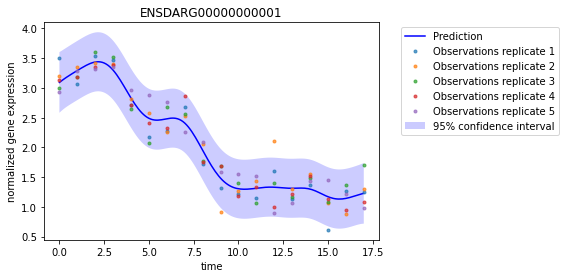

R^2: 0.9477017583004764
delta: 6.16078507391353


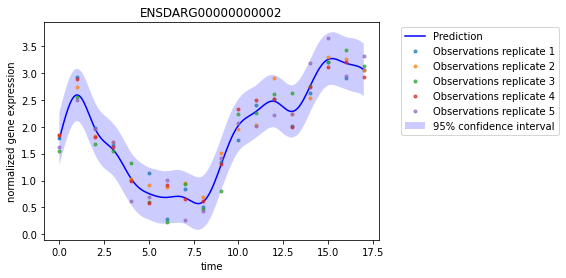

R^2: 0.9750462938880166
delta: 7.742962058294018


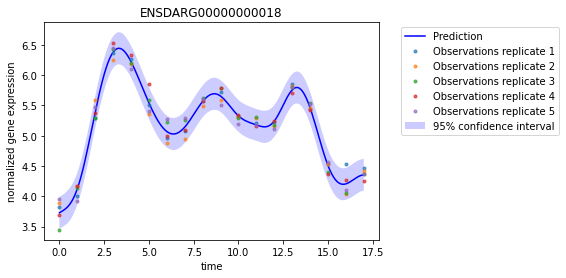

In [6]:
# run 3x with pictures
template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=True, run_n=3)

# currently ran for 
# 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# with 171 points (10 per original timepoint)
new_gpr = False
gpr_inference_file = "data/white_mpf_gpr.tsv"
gpr_scores_file = "data/white_mpf_score.tsv"
if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)

### optional: filter template genes by r2, variability or both

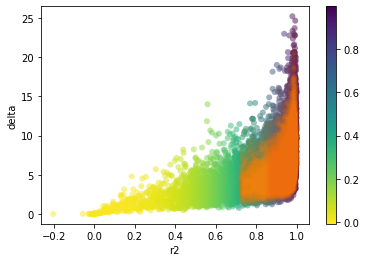

In [7]:
# remove genes that cannot weren't modelled accurately
n = 17_000
gpr_normscores = score_normalization(gpr_scores, weight_expr=0, weight_r2=3)
plot_scores(gpr_normscores, highlight_top_n=n)

top_template_genes = best_n_genes(gpr_normscores, n)

### filter for overlapping (expressed) genes

In [8]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms = tpm_normalization(tpms, sample_order, minimum_value=5, target=target_distribution)
samples2time = {}
for k, v_list in time2samples.items():
    for v in v_list:
        if v not in samples2time:
            samples2time[v] = k           
query_tpms = query_tpms.rename(columns=samples2time)

print(query_tpms.shape)
query_tpms.head(3)

Genes with TPM below 5: 14459 of 32212 (45.0%)
(7224, 106)


,40.0,80.0,120.0,160.0,200.0,240.0,280.0,320.0,360.0,400.0,...,3880.0,3920.0,3960.0,4000.0,4040.0,4080.0,4120.0,4160.0,4200.0,4240.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000018,2.361619,1.300968,2.091439,2.224811,2.355446,2.139688,1.982241,1.487611,2.157660,2.331008,...,1.852740,2.108626,1.761365,2.655474,2.003422,1.938160,1.941568,1.546857,2.345888,1.824053
ENSDARG00000000019,2.391113,1.300968,1.859212,1.960512,2.405970,1.537450,2.568378,2.531808,1.388737,2.188845,...,2.051477,1.368566,0.799732,1.581782,1.623478,1.389388,0.799732,1.690694,2.107863,1.824053
ENSDARG00000000068,2.396991,1.300968,2.526450,0.894162,2.427065,2.416448,2.150492,1.487611,1.388737,1.289732,...,1.294077,0.799732,0.799732,1.581782,0.799732,1.867834,0.799732,1.966826,1.132495,1.824053


In [9]:
# intersection of query genes & top template genes
query_genes = query_tpms.index
starting_genes = set(top_template_genes).intersection(query_genes)

print(len(starting_genes), "overlapping genes")

6841 overlapping genes


### cluster genes

In [10]:
# select number of clusters based on the number of genes
n_clusters = max(10, int(len(starting_genes)/300))
print("n_clusters:", n_clusters)

n_clusters: 22


In [11]:
training_df = template_tpms_inf[template_tpms_inf.index.isin(starting_genes)]

# K-mean setup
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)

# K-means on PCA
reduced_data = PCA(n_components=2).fit_transform(training_df)
kmeans.fit(reduced_data)
k = kmeans.predict(reduced_data)

# # K-means on normalized TPMs data
# kmeans.fit(training_df)
# k = kmeans.predict(training_df)

template_gene_clusters = pd.DataFrame({"gene": training_df.index, "cluster": k})

print(template_gene_clusters.shape)
print(template_gene_clusters.head(3))

(6841, 2)
                 gene  cluster
0  ENSDARG00000000018        0
1  ENSDARG00000000019        2
2  ENSDARG00000000068        0


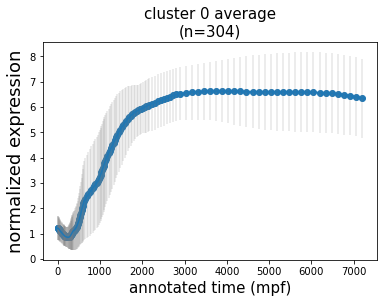

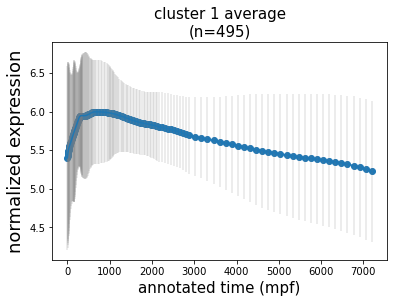

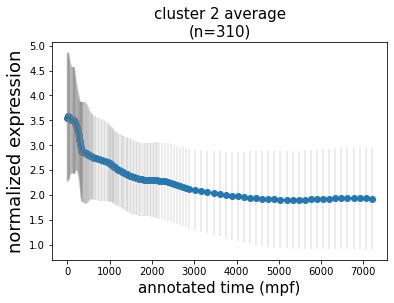

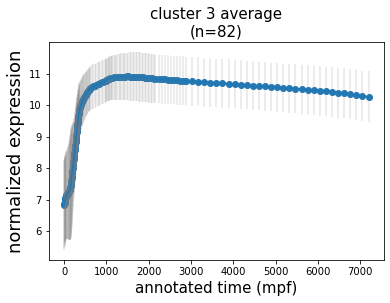

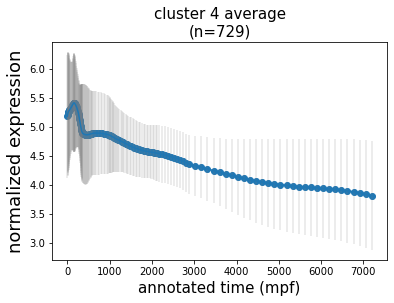

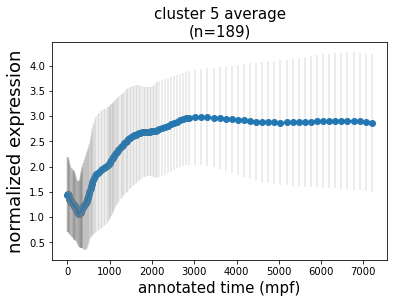

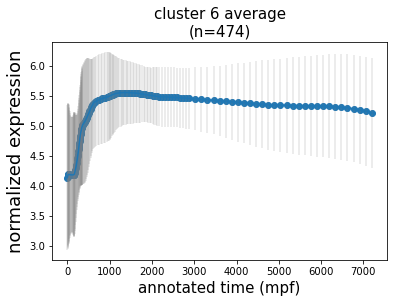

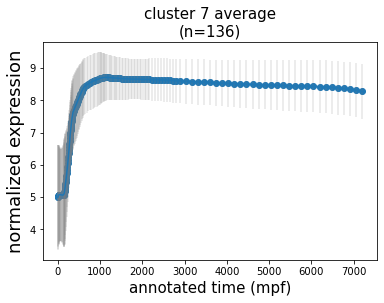

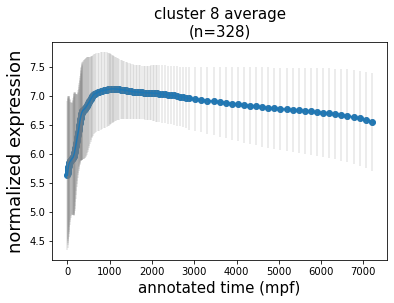

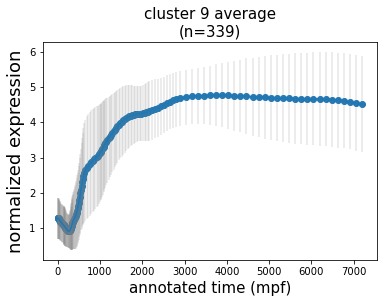

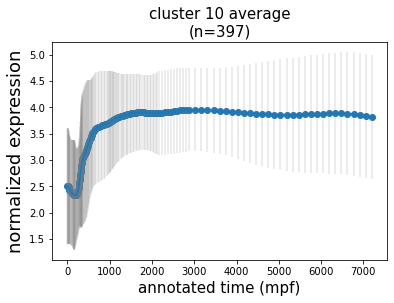

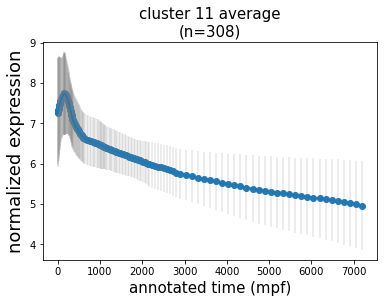

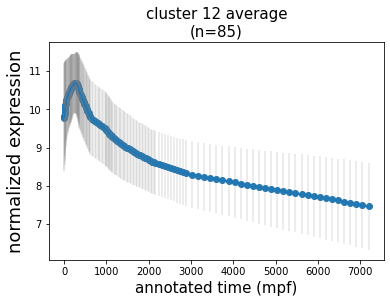

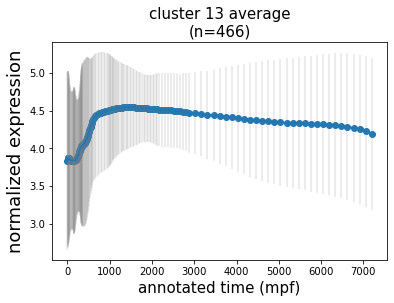

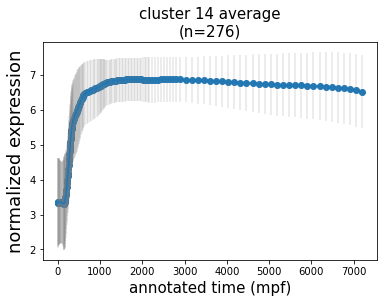

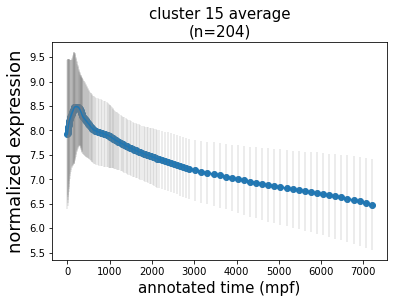

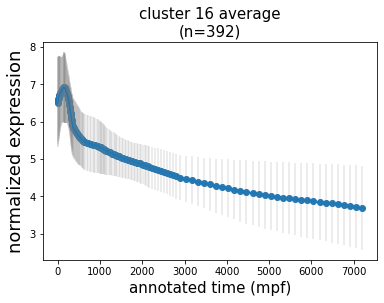

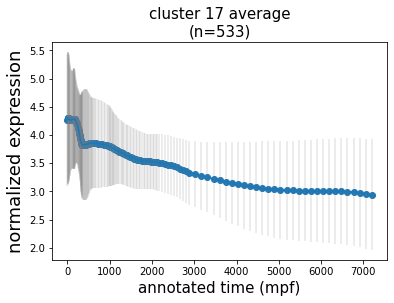

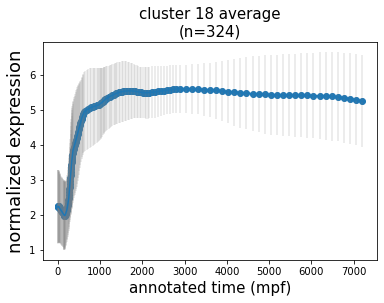

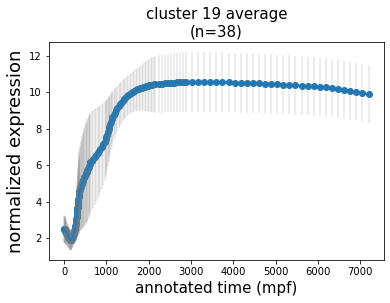

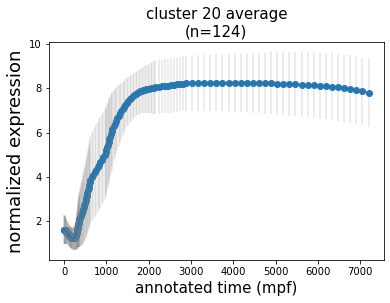

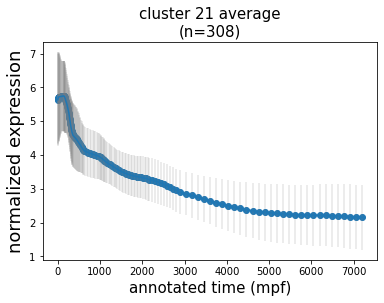

In [12]:
# clustering on TPMs

cluster_x = list2floats(training_df.columns)
for n in range(n_clusters):
    cluster_genes = template_gene_clusters[template_gene_clusters.cluster == n].gene.to_list()
    cluster_tpms = training_df[training_df.index.isin(cluster_genes)]
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.scale(cluster_tpms, axis=1))
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.normalize(cluster_tpms, axis=1))
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.minmax_scale(cluster_tpms, axis=1))
    cluster_y = cluster_tpms.mean()
    cluster_y_std = cluster_tpms.std()
    
    plt.plot(cluster_x, cluster_y)
    plt.scatter(cluster_x, cluster_y)
    plt.errorbar(cluster_x, cluster_y, color="grey", yerr=cluster_y_std, alpha=0.2, fmt='none')
    
    plt.title(f"cluster {n} average\n(n={len(cluster_tpms)})", fontsize=15)
    plt.ylabel("normalized expression", fontsize=18)
    plt.xlabel("annotated time (mpf)", fontsize=15)
    plt.show()
#     break

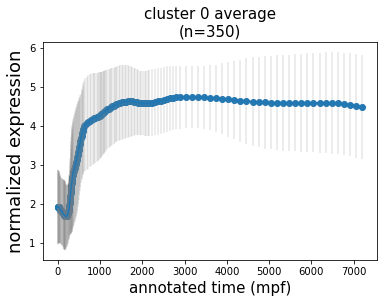

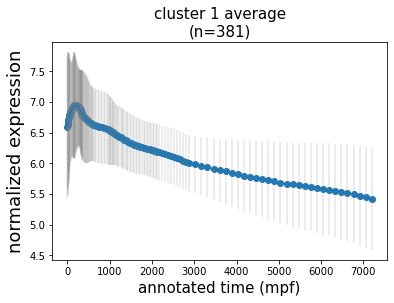

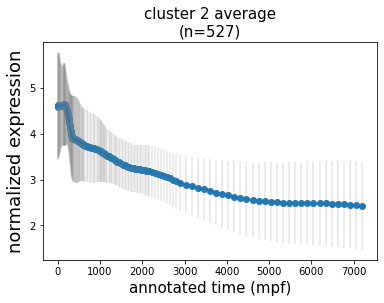

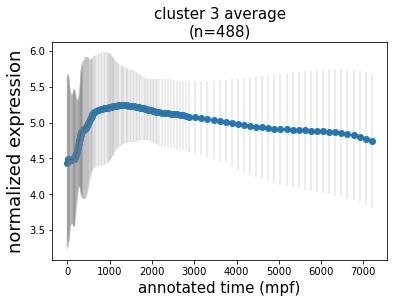

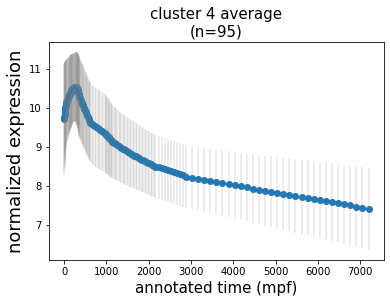

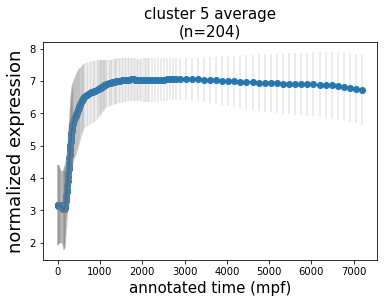

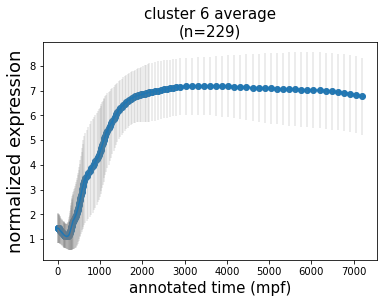

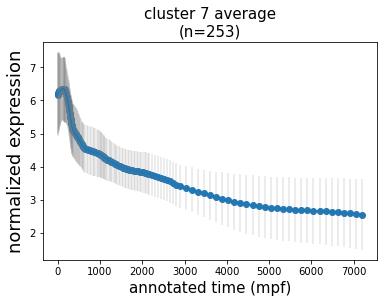

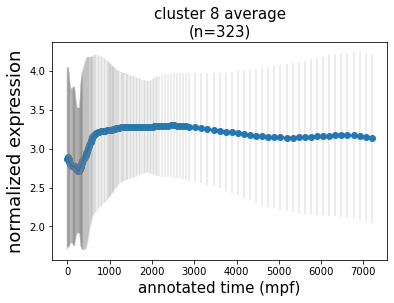

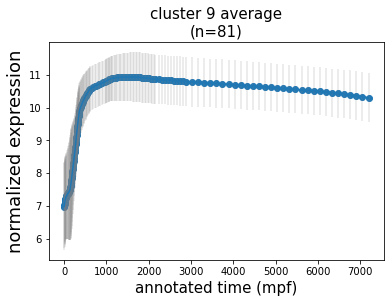

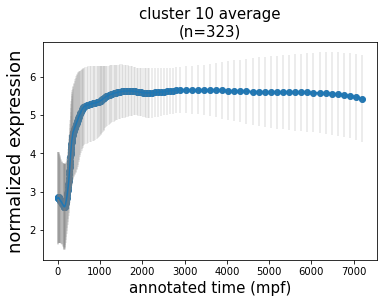

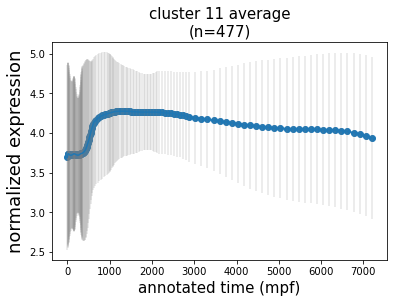

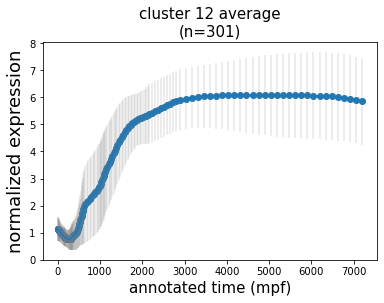

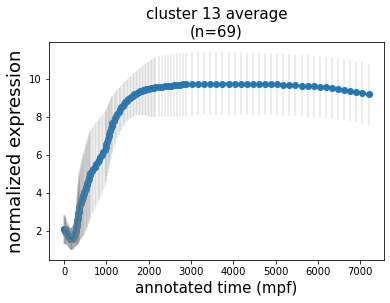

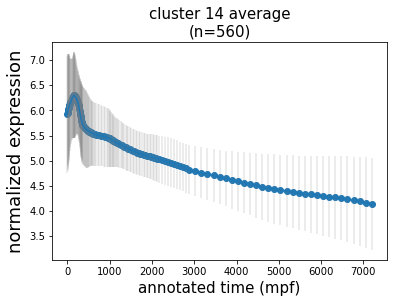

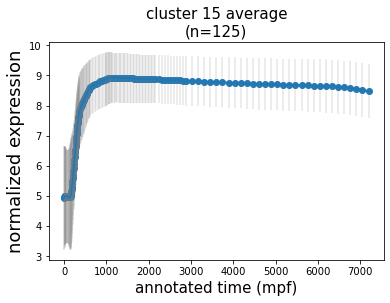

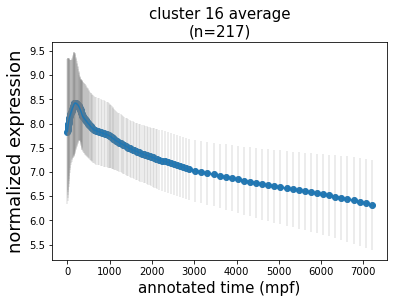

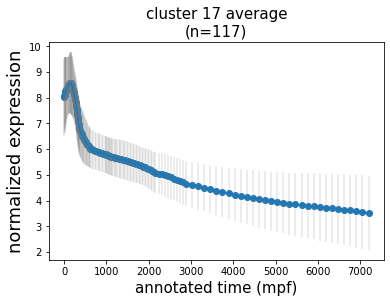

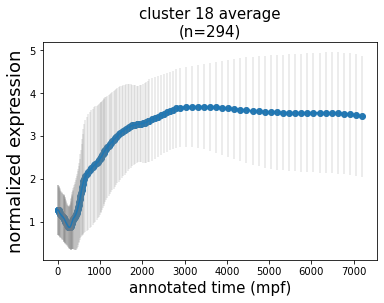

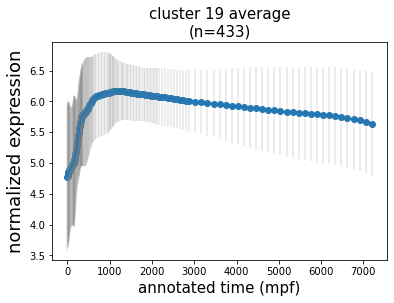

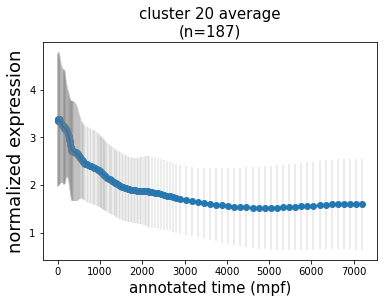

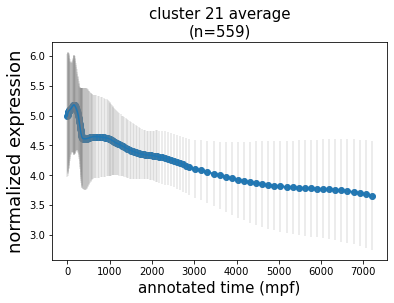

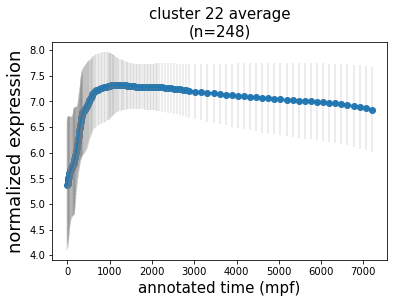

In [187]:
# clustering on PCA(n_components=2)

cluster_x = list2floats(training_df.columns)
for n in range(n_clusters):
    cluster_genes = template_gene_clusters[template_gene_clusters.cluster == n].gene.to_list()
    cluster_tpms = training_df[training_df.index.isin(cluster_genes)]
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.scale(cluster_tpms, axis=1))
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.normalize(cluster_tpms, axis=1))
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.minmax_scale(cluster_tpms, axis=1))
    cluster_y = cluster_tpms.mean()
    cluster_y_std = cluster_tpms.std()
    
    plt.plot(cluster_x, cluster_y)
    plt.scatter(cluster_x, cluster_y)
    plt.errorbar(cluster_x, cluster_y, color="grey", yerr=cluster_y_std, alpha=0.2, fmt='none')
    
    plt.title(f"cluster {n} average\n(n={len(cluster_tpms)})", fontsize=15)
    plt.ylabel("normalized expression", fontsize=18)
    plt.xlabel("annotated time (mpf)", fontsize=15)
    plt.show()
#     break

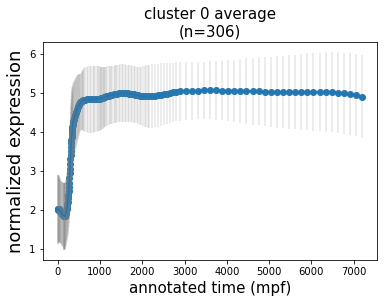

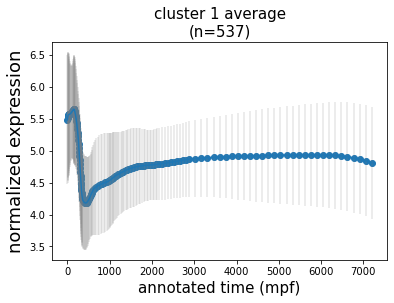

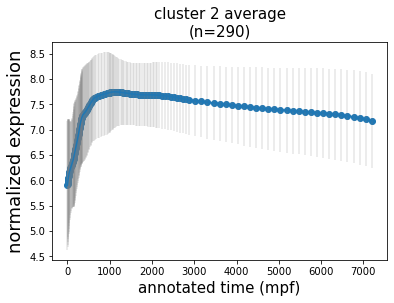

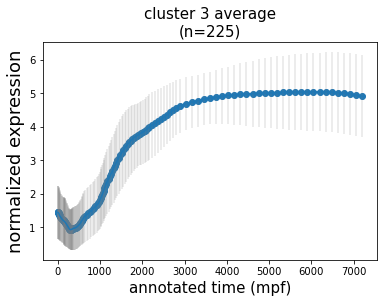

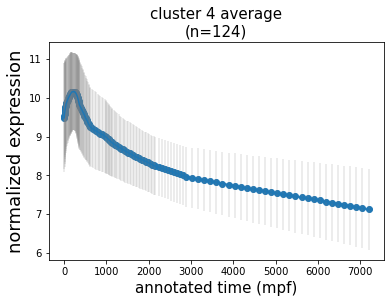

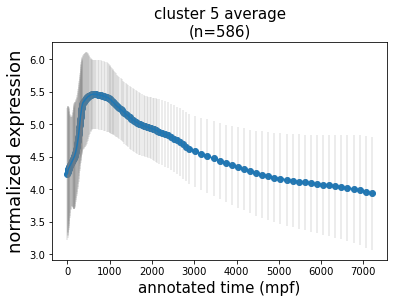

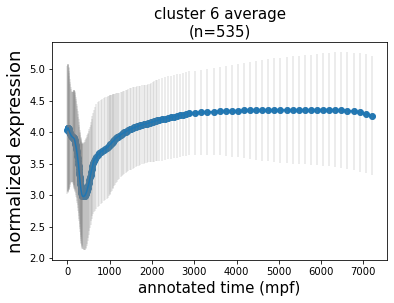

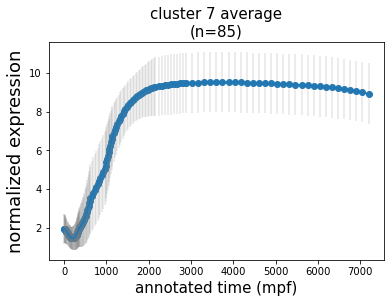

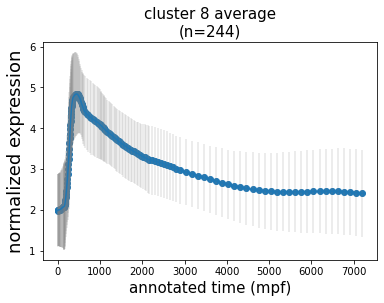

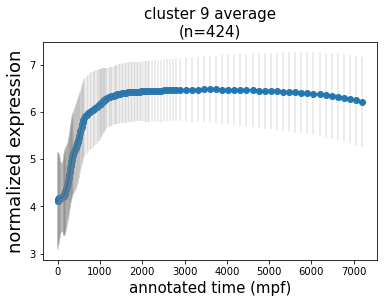

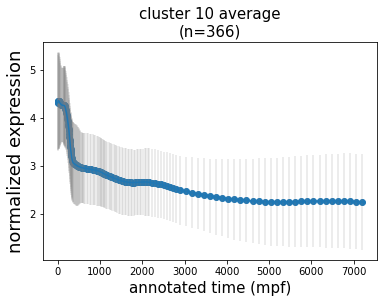

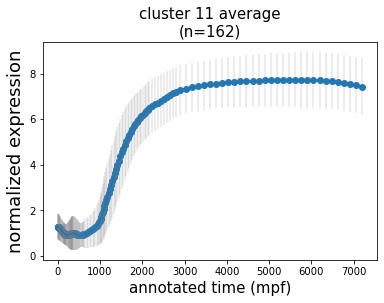

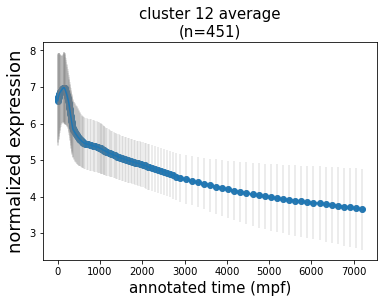

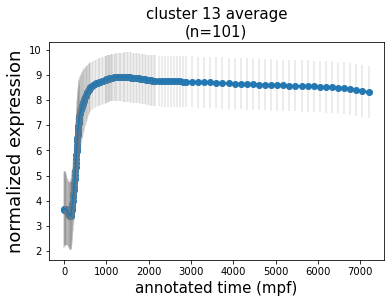

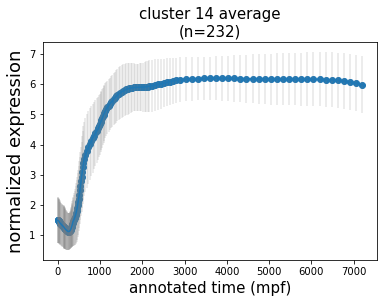

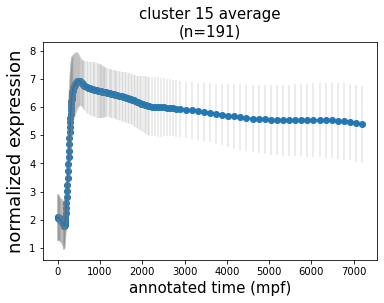

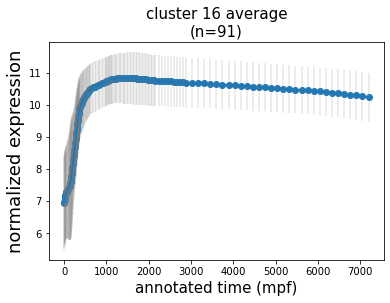

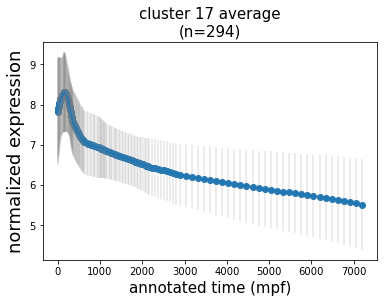

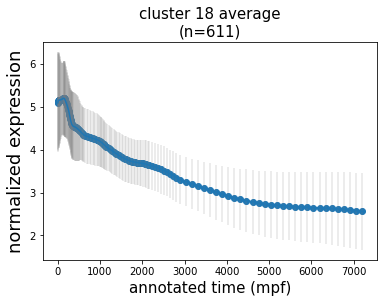

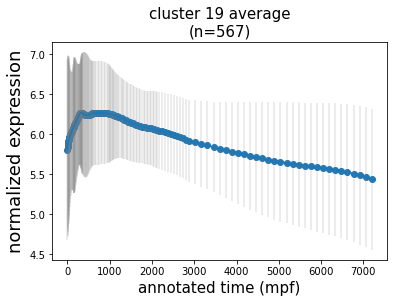

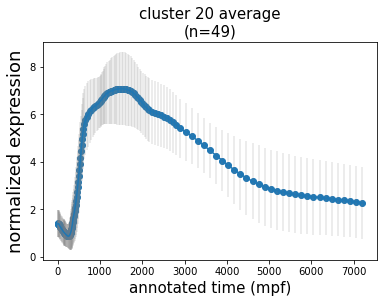

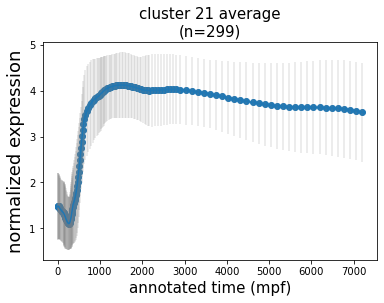

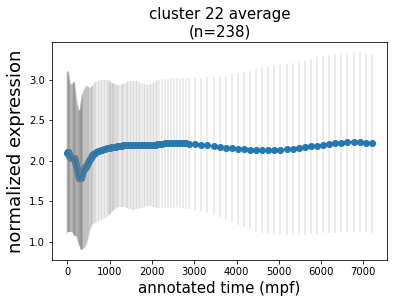

In [172]:
# clustering on PCA(n_components=6)

cluster_x = list2floats(training_df.columns)
for n in range(n_clusters):
    cluster_genes = template_gene_clusters[template_gene_clusters.cluster == n].gene.to_list()
    cluster_tpms = training_df[training_df.index.isin(cluster_genes)]
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.scale(cluster_tpms, axis=1))
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.normalize(cluster_tpms, axis=1))
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.minmax_scale(cluster_tpms, axis=1))
    cluster_y = cluster_tpms.mean()
    cluster_y_std = cluster_tpms.std()
    
    plt.plot(cluster_x, cluster_y)
    plt.scatter(cluster_x, cluster_y)
    plt.errorbar(cluster_x, cluster_y, color="grey", yerr=cluster_y_std, alpha=0.2, fmt='none')
    
    plt.title(f"cluster {n} average\n(n={len(cluster_tpms)})", fontsize=15)
    plt.ylabel("normalized expression", fontsize=18)
    plt.xlabel("annotated time (mpf)", fontsize=15)
    plt.show()
#     break

### Bootstrapping: filter for genes matching cluster (Using PCA)

In [188]:
testing_df = query_tpms[query_tpms.index.isin(starting_genes)]

# K-means on PCA
reduced_data = PCA(n_components=2).fit_transform(testing_df)
k = kmeans.predict(reduced_data)

# # K-means on TPMs
# k = kmeans.predict(testing_df)
query_gene_clusters = pd.DataFrame({"gene": testing_df.index, "cluster": k})

print(query_gene_clusters.shape)
print(query_gene_clusters.head(3))

(6841, 2)
                 gene  cluster
0  ENSDARG00000000018        3
1  ENSDARG00000000019       11
2  ENSDARG00000000068       11


In [213]:
# filter for genes that were clustered together
# requires PCA reduction
df = query_gene_clusters.merge(template_gene_clusters, on="gene", suffixes=["", "_y"])
df = df[df.cluster == df.cluster_y]
df.drop(columns=["cluster_y"], inplace=True)
clusters = df.set_index("gene")

del df
print(clusters.groupby("cluster").size())
clusters

cluster
3     414
11    196
19     34
21      1
dtype: int64


,cluster
gene,
ENSDARG00000000018,3
ENSDARG00000000103,3
ENSDARG00000000690,11
ENSDARG00000000966,11
ENSDARG00000001057,19
...,...
ENSDARG00000109289,11
ENSDARG00000110357,3
ENSDARG00000112002,3


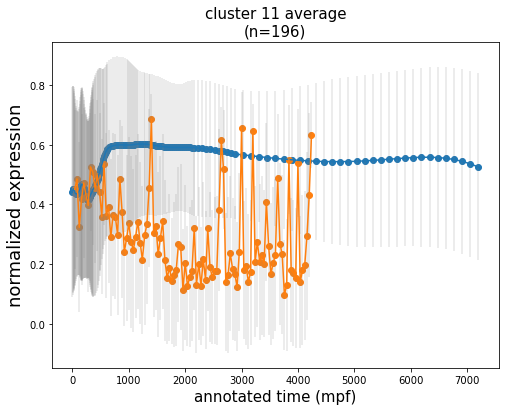

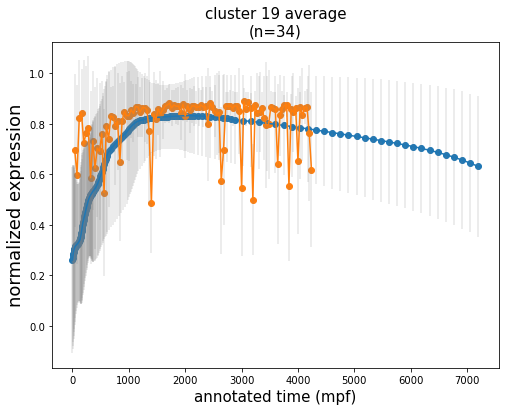

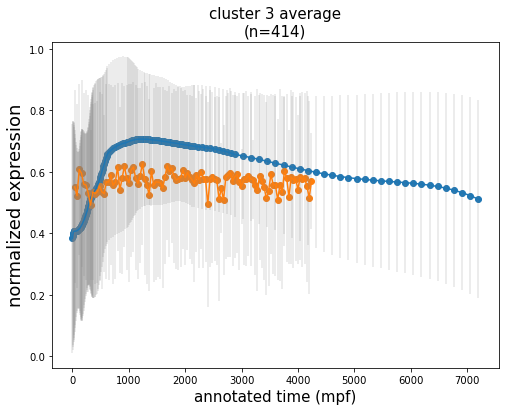

/home/siebrenf/miniconda3/envs/gpr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/siebrenf/miniconda3/envs/gpr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


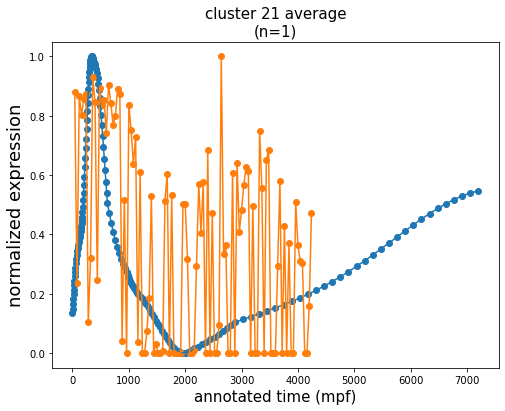

In [237]:
# visualize the remainging clusters
cluster_x = list2floats(template_tpms_inf.columns)
cluster_x2 = list2floats(query_tpms.columns)
for n in set(clusters.cluster):
    cluster_genes = clusters[clusters.cluster == n].index.to_list()
    cluster_tpms = template_tpms_inf[template_tpms_inf.index.isin(cluster_genes)]
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.scale(cluster_tpms, axis=1))
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.normalize(cluster_tpms, axis=1))
    cluster_tpms = pd.DataFrame(sklearn.preprocessing.minmax_scale(cluster_tpms, axis=1))
    cluster_y = cluster_tpms.mean()
    cluster_y_std = cluster_tpms.std()
    
    plt.plot(cluster_x, cluster_y)
    plt.scatter(cluster_x, cluster_y)
    plt.errorbar(cluster_x, cluster_y, color="grey", yerr=cluster_y_std, alpha=0.2, fmt='none')
    
    cluster_tpms2 = query_tpms[query_tpms.index.isin(cluster_genes)]
    cluster_tpms2 = pd.DataFrame(sklearn.preprocessing.minmax_scale(cluster_tpms2, axis=1))
    cluster_y2 = cluster_tpms2.mean()
    cluster_y2_std = cluster_tpms2.std()
    
    plt.plot(cluster_x2, cluster_y2)
    plt.scatter(cluster_x2, cluster_y2)
    plt.errorbar(cluster_x2, cluster_y2, color="grey", yerr=cluster_y2_std, alpha=0.2, fmt='none')
    
    plt.title(f"cluster {n} average\n(n={len(cluster_tpms)})", fontsize=15)
    plt.ylabel("normalized expression", fontsize=18)
    plt.xlabel("annotated time (mpf)", fontsize=15)
    plt.show()
#     break

average TSA after 10 runs with 40% of genes per cluster (n=4)


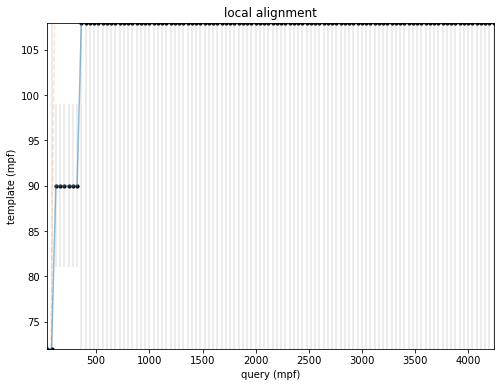

In [230]:
tsa_fraction = 0.4  # use this % of genes per cluster for TSA
tries = 10

# TSA on subset per cluster
paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%", end="\r")
    
    # get a fraction of genes per cluster
    genes = clusters.groupby("cluster").sample(frac=tsa_fraction).index.to_list()

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)]
    
    cost_matrix = get_cost_matrix(t, q, metric='euclidean')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path

# average path of TSAs
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]

# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T

# plot
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
print(f"average TSA after {tries} runs with {int(tsa_fraction*100)}% of genes per cluster (n={len(set(clusters.cluster))})")
plot_alignment(c, avg_path, std_path2)

### Bootstrapping: filter for genes matching cluster (using GPR)

R^2: 0.0034803944412657994
delta: 0.020118352833118802


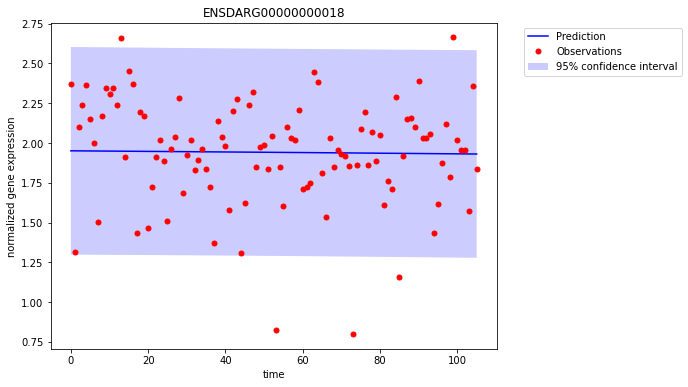

R^2: 0.2107017141170976
delta: 0.7979145448690317


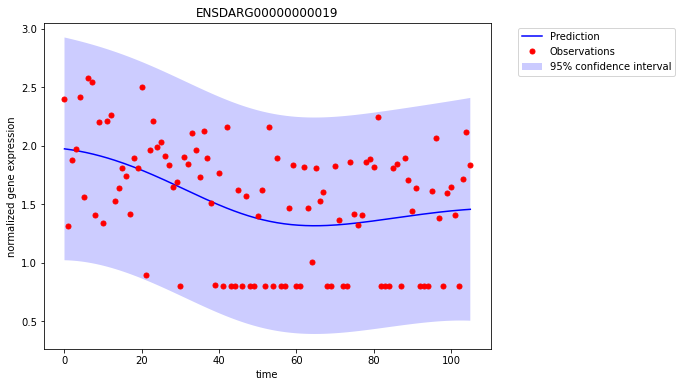

R^2: 0.12237481468927591
delta: 0.5959257868492034


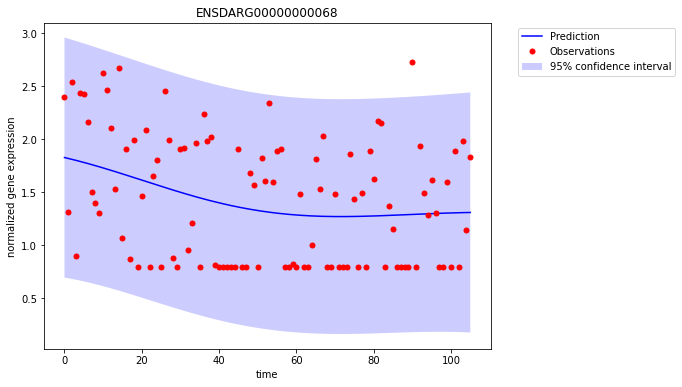

/home/siebrenf/miniconda3/envs/gpr/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


/home/siebrenf/miniconda3/envs/gpr/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [239]:
query_tpms_inf, gpr_scores = gpr(time2samples, query_tpms, extended_timepoints, plot=True, verbose=True, run_n=3)

query_tpms_inf, gpr_scores = gpr(time2samples, query_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)

In [241]:
training_df = template_tpms_inf[template_tpms_inf.index.isin(starting_genes)]

# K-mean setup
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)

# # K-means on PCA
# reduced_data = PCA(n_components=2).fit_transform(training_df)
# kmeans.fit(reduced_data)
# k = kmeans.predict(reduced_data)

# K-means on normalized TPMs data
kmeans.fit(training_df)
k = kmeans.predict(training_df)

template_gene_clusters = pd.DataFrame({"gene": training_df.index, "cluster": k})

print(template_gene_clusters.shape)
print(template_gene_clusters.head(3))

(6841, 2)
                 gene  cluster
0  ENSDARG00000000018       14
1  ENSDARG00000000019       17
2  ENSDARG00000000068        1


In [242]:
testing_df = query_tpms_inf[query_tpms_inf.index.isin(starting_genes)]

# # K-means on PCA
# reduced_data = PCA(n_components=2).fit_transform(testing_df)
# k = kmeans.predict(reduced_data)

# K-means on TPMs
k = kmeans.predict(testing_df)
query_gene_clusters = pd.DataFrame({"gene": testing_df.index, "cluster": k})

print(query_gene_clusters.shape)
print(query_gene_clusters.head(3))

(6841, 2)
                 gene  cluster
0  ENSDARG00000000018       18
1  ENSDARG00000000019       18
2  ENSDARG00000000068       18


In [243]:
# filter for genes that were clustered together
# requires PCA reduction
df = query_gene_clusters.merge(template_gene_clusters, on="gene", suffixes=["", "_y"])
df = df[df.cluster == df.cluster_y]
df.drop(columns=["cluster_y"], inplace=True)
clusters = df.set_index("gene")

del df
print(clusters.groupby("cluster").size())
clusters

cluster
3       1
18    195
dtype: int64


,cluster
gene,
ENSDARG00000000189,18
ENSDARG00000002255,18
ENSDARG00000003008,18
ENSDARG00000004378,18
ENSDARG00000004635,18
...,...
ENSDARG00000112651,18
ENSDARG00000115120,18
ENSDARG00000116433,3


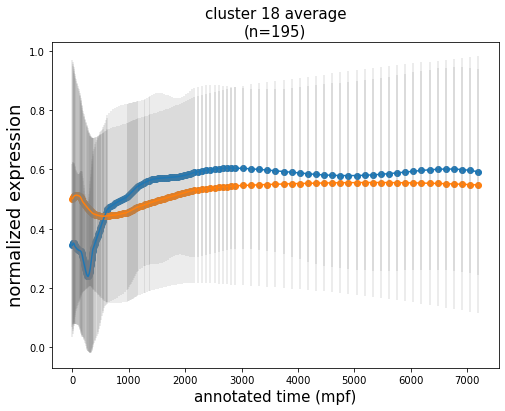

/home/siebrenf/miniconda3/envs/gpr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/siebrenf/miniconda3/envs/gpr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


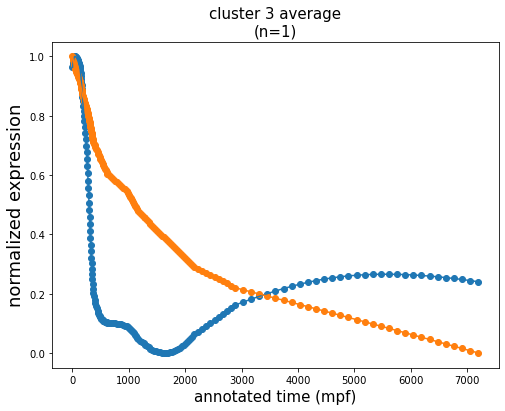

In [245]:
# visualize the remainging clusters
cluster_x = list2floats(template_tpms_inf.columns)
cluster_x2 = list2floats(query_tpms_inf.columns)
for n in set(clusters.cluster):
    cluster_genes = clusters[clusters.cluster == n].index.to_list()
    cluster_tpms = template_tpms_inf[template_tpms_inf.index.isin(cluster_genes)]
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.scale(cluster_tpms, axis=1))
#     cluster_tpms = pd.DataFrame(sklearn.preprocessing.normalize(cluster_tpms, axis=1))
    cluster_tpms = pd.DataFrame(sklearn.preprocessing.minmax_scale(cluster_tpms, axis=1))
    cluster_y = cluster_tpms.mean()
    cluster_y_std = cluster_tpms.std()
    
    plt.plot(cluster_x, cluster_y)
    plt.scatter(cluster_x, cluster_y)
    plt.errorbar(cluster_x, cluster_y, color="grey", yerr=cluster_y_std, alpha=0.2, fmt='none')
    
    cluster_tpms2 = query_tpms_inf[query_tpms_inf.index.isin(cluster_genes)]
    cluster_tpms2 = pd.DataFrame(sklearn.preprocessing.minmax_scale(cluster_tpms2, axis=1))
    cluster_y2 = cluster_tpms2.mean()
    cluster_y2_std = cluster_tpms2.std()
    
    plt.plot(cluster_x2, cluster_y2)
    plt.scatter(cluster_x2, cluster_y2)
    plt.errorbar(cluster_x2, cluster_y2, color="grey", yerr=cluster_y2_std, alpha=0.2, fmt='none')
    
    plt.title(f"cluster {n} average\n(n={len(cluster_tpms)})", fontsize=15)
    plt.ylabel("normalized expression", fontsize=18)
    plt.xlabel("annotated time (mpf)", fontsize=15)
    plt.show()
#     break

### Bootstrapping: Goodness of Fit

In [31]:
training_df = template_tpms_inf[template_tpms_inf.index.isin(starting_genes)]

# K-means clustering on TPMs
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(training_df)
k = kmeans.predict(training_df)

template_gene_clusters = pd.DataFrame({"gene": training_df.index, "cluster": k})

print(template_gene_clusters.groupby("cluster").size())

cluster
0     469
1     504
2      91
3     339
4     289
5     575
6     210
7     400
8      81
9     248
10    242
11    160
12    514
13    546
14    211
15    295
16    481
17    112
18    240
19    161
20    420
21    253
dtype: int64


In [55]:
def scale_df(df):
    return pd.DataFrame(
        sklearn.preprocessing.scale(df, axis=1),
        index=df.index, 
        columns=df.columns
    )

average TSA after 10 runs with 20% of genes per cluster (n=22)


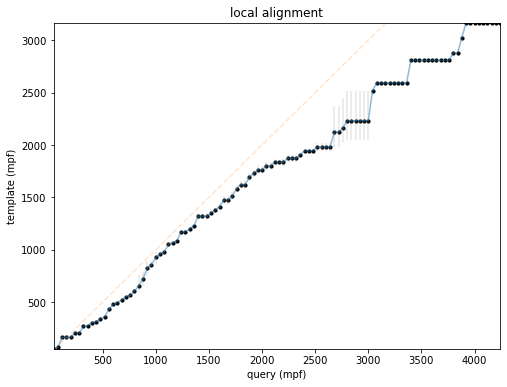

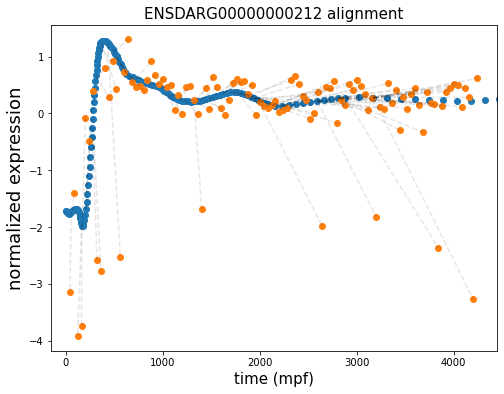

In [65]:
tsa_fraction = 0.2  # use this % of genes per cluster for TSA
# n_genes = 60
tries = 10

# TSA on subset per cluster
paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%", end="\r")
    
    # get a fraction of genes per cluster
    genes = template_gene_clusters.groupby("cluster").sample(frac=tsa_fraction).gene.to_list()
#     genes = template_gene_clusters.groupby("cluster").sample(n=n_genes).gene.to_list()

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)]
    
#     t = scale_df(t)
#     q = scale_df(q)
    
    cost_matrix = get_cost_matrix(t, q, metric='correlation')  # 'euclidean')  # 'cosine')  # 
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path

# average path of TSAs
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]

# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T

# plot
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
print(f"average TSA after {tries} runs with {int(tsa_fraction*100)}% of genes per cluster (n={len(set(template_gene_clusters.cluster))})")
# print(f"average TSA after {tries} runs with {n_genes} genes per cluster (n={len(set(template_gene_clusters.cluster))})")
plot_alignment(c, avg_path, std_path2)

showcase_gene = "ENSDARG00000000212"
plot_gene(showcase_gene, query_tpms, template_tpms_inf, avg_path, scale=True)

### r2 is euclidean
better with scaling, but is there something better?

In [66]:
# get 2 dataframe with desired genes and aligned timepoints
template_Y = subset_df(template_tpms_inf, starting_genes, avg_path)
query_Y = subset_df(query_tpms, starting_genes)

# scale y-axis per gene
template_Y = pd.DataFrame(
    sklearn.preprocessing.scale(template_Y, axis=1),  # sklearn.preprocessing.minmax_scale(
    index=template_Y.index, 
    columns=template_Y.columns
)
query_Y = pd.DataFrame(
    sklearn.preprocessing.scale(query_Y, axis=1),
    index=query_Y.index, 
    columns=query_Y.columns
)

# R^2: how close are the two time series? (argument order is arbitrary)
scores = sklearn.metrics.r2_score(query_Y.T, template_Y.T, multioutput='raw_values')
scores = pd.DataFrame({"gene": query_Y.index, "score": scores})

print(scores[scores.gene==showcase_gene])

                 gene     score
8  ENSDARG00000000212  0.018713


In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

# get 2 dataframe with desired genes and aligned timepoints
template_Y = subset_df(template_tpms_inf, starting_genes, avg_path)
query_Y = subset_df(query_tpms, starting_genes)

# scale y-axis per gene
template_Y = pd.DataFrame(
    sklearn.preprocessing.scale(template_Y, axis=1),  # sklearn.preprocessing.minmax_scale(
    index=template_Y.index, 
    columns=template_Y.columns
)
query_Y = pd.DataFrame(
    sklearn.preprocessing.scale(query_Y, axis=1),
    index=query_Y.index, 
    columns=query_Y.columns
)
scores = sklearn.metrics.r2_score(query_Y.T, template_Y.T, multioutput='raw_values')

# scores = []
# for gene in query_Y.index:
#     t = template_Y.loc[gene]
#     q = query_Y.loc[gene]
#     score = pearsonr(t, q)[0]
#     scores.append(score)

# scores = []
# for gene in query_Y.index:
#     t = template_Y.loc[gene].to_numpy().reshape(1,-1)
#     q = query_Y.loc[gene].to_numpy().reshape(1,-1)
#     score = cosine_similarity(t, q)[0][0]
#     scores.append(score)

# scores = []
# for gene in query_Y.index:
#     t = template_Y.loc[gene].to_numpy().reshape(1,-1)
#     q = query_Y.loc[gene].to_numpy().reshape(1,-1)
#     score = cdist(t, q, metric="correlation")[0][0]
#     scores.append(score)

scores = pd.DataFrame({"gene": query_Y.index, "score": scores})

print(scores[scores.gene==showcase_gene])

In [67]:
# subset per cluster by fit
fraction = 0.2

# combine score and cluster info per gene
# subset = pd.DataFrame({"gene": gene_set, "score": scores})
subset = scores
subset = subset.merge(template_gene_clusters, on="gene", how="right")
print("All genes per cluster")
print("mean fit score:", round(subset.score.mean(), 3))
s = subset.groupby("cluster").score.mean()
g = subset.groupby("cluster").size()
g.name = "n_genes"
print(pd.concat([s, g], axis=1))

print()

# take the top fraction of each cluster
subset.sort_values("score", ascending=False, inplace=True)
subset = subset.groupby("cluster").apply(lambda x: x.head(int(len(x)*fraction))).reset_index(drop=True)  # top fraction/cluster
# subset = subset[subset.score > 0]  # minimum score
print("Top genes per cluster")
print("mean fit score:", round(subset.score.mean(), 3))
s = subset.groupby("cluster").score.mean()
g = subset.groupby("cluster").size()
g.name = "n_genes"
print(pd.concat([s, g], axis=1))
subset = subset.gene.to_list()

All genes per cluster
mean fit score: -0.311
            score  n_genes
cluster                   
0       -0.580430      469
1       -0.473527      504
2        0.166243       91
3       -0.360464      339
4       -0.267298      289
5       -0.492882      575
6       -0.267746      210
7       -0.231920      400
8        0.502375       81
9       -0.629942      248
10      -0.170376      242
11       0.047711      160
12      -0.454118      514
13      -0.424887      546
14       0.104763      211
15      -0.123577      295
16      -0.443756      481
17      -0.211097      112
18       0.140018      240
19       0.465310      161
20      -0.348333      420
21      -0.388946      253

Top genes per cluster
mean fit score: 0.179
            score  n_genes
cluster                   
0       -0.033505       93
1        0.098521      100
2        0.629421       18
3        0.103885       67
4        0.295876       57
5       -0.035319      115
6        0.306638       42
7        0.201757  

average TSA after 10 runs with 20% of genes per cluster (n=22)


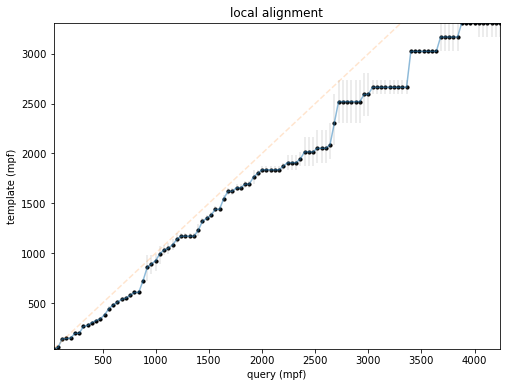

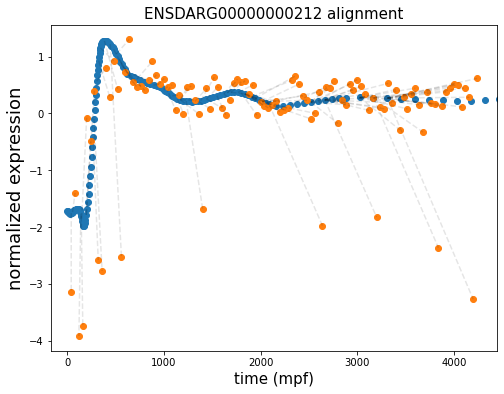

In [69]:
tsa_fraction = 0.2  # use this % of genes per cluster for TSA
# n_genes = 10
tries = 10

subset_template = template_gene_clusters[template_gene_clusters.gene.isin(subset)]

# TSA on subset per cluster
paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%", end="\r")
    
    # get a fraction of genes per cluster
#     genes = template_gene_clusters.groupby("cluster").sample(frac=tsa_fraction).gene.to_list()
#     genes = subset#template_gene_clusters.groupby("cluster").sample(n=n_genes).gene.to_list()
    genes = subset_template.groupby("cluster").sample(frac=tsa_fraction).gene.to_list()
#     genes = subset_template.groupby("cluster").sample(n=min(n_genes, x)).gene.to_list()

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)]
    
#     t = scale_df(t)
#     q = scale_df(q)
    
    cost_matrix = get_cost_matrix(t, q, metric='correlation')  # 'euclidean')  # 'cosine')#
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path

# average path of TSAs
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]

# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T

# plot
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
print(f"average TSA after {tries} runs with {int(tsa_fraction*100)}% of genes per cluster (n={len(set(template_gene_clusters.cluster))})")
# print(f"average TSA after {tries} runs with {n_genes} genes per cluster (n={len(set(template_gene_clusters.cluster))})")
plot_alignment(c, avg_path, std_path2)

showcase_gene = "ENSDARG00000000212"
plot_gene(showcase_gene, query_tpms, template_tpms_inf, avg_path, scale=True)